In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random as rng
%matplotlib inline

In [3]:
# Modeling queen egg laying behavior

# Egg laying of a queen is dependent on adult working population, day-length, resource influx, and ambient temperature

## This seasonal profile season(t) is perhaps an oversimplification of the weather and we can try to complicate it 

def season(t, x1, x2, x3, x4, x5):
    '''
    Function to define a seasonal factor as a function of t, in days. It influences daily egg laying rate of queen,
    and nectar and pollen availability in the environment
    
    Args:
        t: (int) day number. Measured since as # since Jan 1st
        xi:    (floats)    Parameters that influence the shape of the season factor and can be adjusted to adjust for different climates

    Out:
        seasonValue:    (float) the season factor function at time t
    
    '''
    poss1 = 1 - (1/(1+x1*np.exp(-2*t/x2)))
    poss2 = (1/(1+x3*np.exp(-2*(t-x4)/x5)))
    seasonValue = np.maximum(poss1,poss2)
    return seasonValue

# HoPoMo includes a suppression factor SUPcomb(t) to describe suppression in egg laying when available empty space in the 
#  hive is below the threshold parameter SUPthreshold 
# The gradual lowering off egg laying rate is interpreted as the increased searching time for an empty cell 
# To calculate ratio of available empty cells to total cells, they defined a constant CELLSHive as the total number of cells in a hive

# Since we will likely only be interested in modeling 10 frame brood boxes, we will likely avoid implementing SUPcomb(t)


SUPthreshold = 50

# Constants representing number of cells in frames and hive
CELLSperframe = 9000
FRAMESperhive = 10
CELLShive = CELLSperframe*FRAMESperhive

def CELLSempty(t):
    value = CELLSHive - CELLSbrood(t)-STORESpollen(t)-STORESnectar(t)-STOREShoney(t)
    return value

def SUPcomb(t):
    if (CELLSempty(t)/(CELLShive+1))<SUPthreshold:
        value = CELLSempty(t)/((CELLShive+1)*SUPthreshold)
    else:
        value = 1
    return value

# To account for variability in Queen laying rates even with available cells, implemented a stochastic factor ELRstoch(t)
# ELRstoch is assumed to be uniformaly distributed around 0 from -ERLstochrange to +ERLstochrange

ELRstochrange = 10.

# ELRbase is the mean daily egg laying rate of the queen at the maximum egg laying peak in Spring
# Queen also differ individually in max egg laying capacity, so this is also a genetic factor
# Additionally, this base number can be used to model queen age
ELRbase = 10.

def ELRstoch(t):
    return rng.uniform(-ERLstochrange, ERLstochrange)
    
def ELR(t):
    '''
    Function to model the daily laying rate of a queen
    
    Args:
        t: (int) day number. Measured since as # since Jan 1st

    Out:
        layRate:    (float) the laying rate for a queen on a given day
    '''
    layRate = ELRbase * (1 + ELRstoch(t))*(1-season(t))*SUPcomb(t)

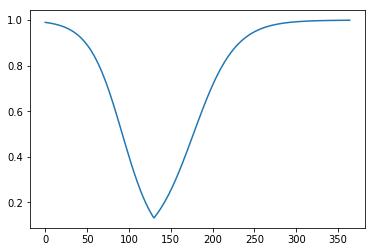

In [4]:
# Testing season(t)
x1 = 100
x2 = 40
x3 = 800
x4 = 100
x5 = 50
year = np.arange(365)
plt.plot(year, season(year, x1, x2, x3, x4, x5))

In [9]:
# Modeling brood development

# Constants that stand for the development period for 
LIFESPANegg = 3
LIFESPANlarvae = 5
LIFESPANpupa = 12

# Constants that represent the initial population state of the colony
INITeggs = 10
INITlarvae = 10
INItpupae = 10

# Daily egg mortality, treated as a constant in this model
MORTALITYeggs = 10

# Model for the amount of brood at each day t, where i indicates the age of the immature individual, in days

def EGGS(i, t):
    if i ==1:
        value = ELR(t-1)(1-MORTALITYeggs)
    elif (i==2 or i==3):
        value = EGGS(i-1, t-1)(1-MORTALITYeggs)
    elif i>3:
        print('These are no longer eggs. It should have called the Larvae function')
        return None
    return value

# Time independent base mortality of larvae
MORTALITYlarvae = .1

# Rate of cannabilism of larvae depends on size of nurse population, pollen status of the colony, and age specific canabalism rate (CANNABILISMhungerbase(i))
def CANNIBALISMlarvae(i,t):
    value = CANNABILISMhungerbase(i)*(1-(INDEXpollensituation(t-1)*INDEXnursingquality(t-1)))
    return value

# Rate of survival of larvae depends on cannibalism rate and base survival rate 
def SURVIVALlarvae(i,t):
    value = (1-CANNABILISMlarvae(i,t))*(1-MORTALITYlarvae)
    return value
        
def LARVAE(i,t):
    if i =1:
        value = EGGS(LIFESPANegg, t-1)*SURVIVALlarvae(1,t)    
    elif i<=LIFESPANlarva:
        value = LARVAE(i-1,t-1)*SURVIVALlarvae(i,t)
    elif i>LIFESPANlarva:
        print('These are no longer larva. It should have called the Pupae function')
        return None
    return value

# Mortality rate of pupae, treated as a constant here, and it is usually signicantly smaller than that for eggs or larvas
MORTALITYpupae = .5

# Calculates the age demography of all sealed brood, treating the first day after a cell being sealed as the same as the actual pupae stage
# All sealed brood does not require feeding from nurse bees, which is why we group it all as pupae
def PUPAE(i,t):
    if i = 1:
        value = LARVAE(LIFESPANlarva, t-1)*(1-MORTALITYpupae)
    elif i<=LIFESPANlarva:
        value = PUPAE(i-1,t-1)*(1-MORTALITYpupae)
    elif i>LIFESPANlarva:
        print('These are no longer Pupae. It should have called the bee function')
        return None
    return None
    
# Function that returns the number of cells that have eggs
# The number of 1-day-old eggs is derived from the egg laying rate on the previous day (ELR(t-1)). 
# The number of 2- or 3-day-old eggs is derived from the number of eggs 1 day younger on the previous day (EGGS(i-1,t-1))
def CELLSeggs(t):
    value = 0
    for i in range(LIFESPANegg):
        # The +1 is to make i represent the age of the growing bees 
        value += EGGS(i+1,t)
    return value

# Function that returns the number of cells that have unsealed larvae
def CELLSlarvae(t):
    value = 0
    for i in range(LIFESPANlarva):
        # The +1 is to make i represent the age of the growing bees 
        value += LARVAE(i+1,t)
    return value


# Function that returns the number of cells that have sealed brood
def CELLSpupae(t):
    value = 0
    for i in range(LIFESPANpupa):
        # The +1 is to make i represent the age of the growing bees 
        value +=PUPAE(i+1,t)
    return balue

# Total number of cells with brood
def CELLSbrood(t):
    value = CELLSeggs(t)+CELLSlarvae(t)+CELLSpupae(t)
    return value

SyntaxError: invalid syntax (<ipython-input-9-c814a8a84f50>, line 8)

In [4]:
# Modeling adult bee population


# Returns the overall daily mortality rate of the adult bee population based on a constant mortality rate, as well as task specific mortality rates

# We use the numbers of bees on the previous day (t-1) in to prevent a circular formula definition with BEESadult(t)
# MORTALITYforaging is a constant factor because the influence of environmental conditions on forager mortality is baked into 
# the calculation of FORAGERSactive(t). Considers environmental conditions (temperature, rain and environmental resource availability)
# as well as the internal status of the colony (demand, foraging workforce, processing workforce) affect the size of
# FORAGERSactive(t) and thus affect automatically the fraction of foraging-caused mortality within the overall adult mortality.

def MORTALITYadult(t):
    # Contribution to total population mortality is weighted by portion of bees performing the task on a given day
    NURSErate = MORTALITYnursing*(NURSES(t-1)/(BEESadult(t-1)+1)) 
    PROCESSORrate = MORTALITYprocessing*(PROCESSORS(t-1)/(BEESadult(t-1)+1))
    FORAGERrate = MORTALITYforaging*(FORAGERSactive(t-1)/(BEESadult(t-1)+1))
    value = MORTALITYadultbase + NURSErate + PROCESSORrate + FORAGERrate
    return value

# Constant mortality rates for adult bees, and task specific mortality rate
MORTALITYadultbase = .1
MORTALITYnursing = .1
MORTALITYprocessing = .1
MORTALITYforaging = .1

# Returns the number of adult bees on a given day, based on the number newly hatched adult bees and the survival of adult bees from the previous day
def BEESadult(t):
    value = (BEESadult(t-1) + PUPAE(LIFESPANpupa, t-1))*(1 - MORTALITYadult(t))
    return value


In [5]:
# Modeling environmental influence

In [6]:
# Modeling task decision-making

In [7]:
# Modeling the regulation of foraging

In [8]:
# Modeling resource influx into a hive

In [9]:
# Modeling the food regulation 

In [ ]:
# Modeling nutrient management